## PHYS 481 Assignment 3

October, 2018

Kenneth Sharman (00300185)

In [1]:
import numpy as np 
import matplotlib.pyplot as plt

## Introduction

So far in PHYS 481 we have covered data manipulation, random processes, and entropy. These three concepts will be the backbone of this report. An interesting blend of computer science and the physical sciences can be seen in models called cellular automaton. We will work our way through the basics of the one-dimensional case, then apply that knowledge to two dimensions by implementing Conway's Game of Life.

The goal is to become comfortable with a very simple model, in terms of both the code required and the specifics of the system itself. Further, a physics component will be added to the analysis, namely entropy, which will help us better understand how to classify the system.

This model has a bit of a learning curve and as such, requires careful and diligent analysis of the basics. Question #1 in this report serves that purpose. For the remaining questions our understanding of the model is put to use and some very interesting results are observed.

### #1 Explain how to calculate and classify basic 1-dimensional automata

In my discrete mathematics course, the concept of a "finite-state automaton" was introduced. Every input to a finite-state automaton "machine" leads to a change in the state of the automaton. Further, that state of the machine determines how input is processed$^1$. Here, we will be analyzing cellular automata. The machine in this case can be viewed as a grid of cells, and each cell possesses a state. Given a set of rules which are a function of the current state, we can observe how such a system will change over time. This model sounds simple; however it can become relatively complex. Stephen Wolfram published "A New Kind of Science" in 2002, which showed how cellular automata are relevant to many areas of science.$^2$

We will walk through the steps outlined in https://natureofcode.com/book/chapter-7-cellular-automata/ which describes how to implement a 1-dimensional cellular automaton in code.

To start we can identify three key elements of a CA (cellular automaton):

1. The <u>grid</u>. We will use a numpy array to represent the grid, as it is in general faster than using python lists.
2. Each element of the array (a cell) has a <u>state</u>. We will use a bit to represent the state ($0$ or $1$).
3. Define the <u>neighborhood</u> of a cell as the cells to left and right. 

To implement a set of rules which describes how the system will change over time, we will consider the cells, one at a time, and classify their state using the following 3-bit number (remember that the state is $0$ or $1$):

$$[\text{state of left neighbor}] \; , \; [\text{state of cell}] \; , \; [\text{state of right neighbor}]$$

If we establish a rule for each 3-digit binary number, then the we can determine the state of a cell in a later time (referred to as a later 'generation').

Since we will be using binary numbers, we must first look at how we can deal with them in Python.

#### Converting decimal to binary.

Binary numbers are base 2. These numbers use only the <u>b</u>inary dig<u>it</u>s.
    
Unsigned integers of N-bits range from $0$ to $2^{N}-1$.

For our preliminary analysis we will use 1 byte = 8-bit unsigned integers.

In decimal 8-bit numbers have the range: $0-255$ and in binary: $00000000$ to $11111111$.

We will need to determine the binary values for integers. The "standard" way of doing it is as follows:

In [2]:
for i in range(0,6):
    print('Binary Representation of', i, ':', np.unpackbits( np.uint8(i) ))
# uint8 typecasts number to an unsigned integer
# unpackbits converts uint8 to binary

Binary Representation of 0 : [0 0 0 0 0 0 0 0]
Binary Representation of 1 : [0 0 0 0 0 0 0 1]
Binary Representation of 2 : [0 0 0 0 0 0 1 0]
Binary Representation of 3 : [0 0 0 0 0 0 1 1]
Binary Representation of 4 : [0 0 0 0 0 1 0 0]
Binary Representation of 5 : [0 0 0 0 0 1 0 1]


However, this method is costly, as it calls a function within another function. Our in-class notes for this week covered various methods of converting to binary, and used timeit to display runtimes. The bin method was the fastest, even with the extra formatting. To ensure that our code is as optimized as possible we will use this method.

In [3]:
# Note the output of the bin function
for i in range(0,6):
    print('Binary Representation of', i, ':', bin(i)) # bin converts integer to binary
print( type( bin(0) ) )

Binary Representation of 0 : 0b0
Binary Representation of 1 : 0b1
Binary Representation of 2 : 0b10
Binary Representation of 3 : 0b11
Binary Representation of 4 : 0b100
Binary Representation of 5 : 0b101
<class 'str'>


There are two important things to notice here.

First, the output of the bin function is a string.

Second, the output contains the prefix 'ob'. Note that the '0' indicates to the compiler that it has encountered a constant (as opposed to a reference variable or reserved word), and the 'b' indicates the number base. In this case the 'b' is for binary, which is of base 2.

For our analysis we do not want the prefix, and we do want the full 8-digit number. Here is where we will modify the output string. The comments in the following block of code explain how this is done.

<pre>
# Python allows you to access the characters of a string, similar to accessing elements in an array

bin(some_string)[2:] # Use full string exluding the first two elements; some_string[0] and some_string[1]
bin(some_string)[2:].zfill(8) # The zfill function pads the string on the left with zeros. 

In our case we make the string 8 "digits" long to match the 8 bits in a byte.
</pre>

We will define a function that formats the output of the bin function.

In [4]:
def binaryRep(num, num_bits, numpy_array=False):
    '''
    Calculates the binary representation for a given number of bits.
    Function requires that the parameter num is a positive integer.
    Parameters:
        num: Number whose binary value we want
        num_bit: Number of bits used in binary representation
        numpy_array: If True, return binary number stored in numpy array 
    Returns
        Binary representation of number with specified number of bits
    '''
    # Only unsigned integers will be accepted
    assert num >= 0, 'Negative Values are not acceptable'
    assert num%1 == 0, 'Number must be an integer'
    
    # Verify the number fits into specified number of bits
    assert num <= (2**num_bits - 1), 'Number too large for that many bits'
    
    result = bin(num)[2:].zfill(num_bits) # Remove prefix and pad on left with zeros
    
    # Return type is by default a string but optionally can be in form a numpy array
    if numpy_array == True:
        result = np.array( [ int(num) for num in result  ] )
    
    return result

Getting in the habit of testing code, we will define a function that checks boundary conditions of an 8-bit binary.

In [5]:
def test_binaryRep():
    '''
    Function performs 3 tests on the binaryRep function. The min and max 8-bit numbers are checked
    as well as a 16-bit number
    '''
    # Check 8-bit boundaries
    num0 = '00000000' # 0 in 8-bit binary
    num255 = '11111111' # 255 in 8-bit binary (max number using 8 bits)
    # Also check a 16-bit number
    num256 = '0000000100000000' # 256 in 16-bit binary
    
    assert num0 == binaryRep(0, 8), 'Function failed to properly calculate 0'
    assert num255 == binaryRep(255, 8), 'Function failed to properly calculate 255'
    assert num256 == binaryRep(256, 16), 'Function failed to properly calculate 256'
    
test_binaryRep()

Example output of binaryRep function:

In [6]:
number = 110
print( '110 in binary (String):', binaryRep(number, 8) )
print( '110 in binary (Numpy Array):', binaryRep(number, 8, numpy_array=True) )

110 in binary (String): 01101110
110 in binary (Numpy Array): [0 1 1 0 1 1 1 0]


Next, rules that govern how states change from generation to generation will be considered. The 1-dimensional CA model will require that we use 3-bits (the cell and its neighbors) to look up a given rule.

As mentioned in the class notes, the simplest and fastest method is to use numpy array indexing, however we will start with an unoptimized version and use Python dictionaries.

For each 3-bit number, we assign a resulting state. In terms of a dictionary, the keys can be all possible 3-bit numbers. There are eight possibilities ($2^3=8)$. Each key needs a value, which represents the future state. Thus, a rule can be described by an 8-bit number. Since there are 256 possible 8-bit binary numbers ($2^8$) there are 256 rules, from $0$ to $255$ ($2^8 - 1$). 

Before implementing a dictionary, it is useful to "visualize" the mapping using a series of 'if else-if' control structures. 

In [7]:
# Determine new cells using if-else statements
def rules(a, b, c, rule_number):
    '''
    Determines next generation state for cell b, with neighbors a and c (left and right), based
    on the passed rule_number.
    Returns new state of cell b
    '''
    
    ruleset = binaryRep(rule_number, 8) # Generate 8-bit binary number representing rule number
    
    if (a == 1 and b == 1 and c == 1): # If (1,1,1)
        return ruleset[0] # Return first number in ruleset array
    
    elif (a == 1 and b == 1 and c == 0): # If (1,1,0)
        return ruleset[1] # Return second number in ruleset array
    
    elif (a == 1 and b == 0 and c == 1): # etc ...
        return ruleset[2]
    
    elif (a == 1 and b == 0 and c == 0):
        return ruleset[3]
    
    elif (a == 0 and b == 1 and c == 1):
        return ruleset[4]
    
    elif (a == 0 and b == 1 and c == 0):
        return ruleset[5]
    
    elif (a == 0 and b == 0 and c == 1):
        return ruleset[6]
    
    elif (a == 0 and b == 0 and c == 0):
        return ruleset[7]

The Nature of Code document$^2$ assigned 3-bit numbers to this rule in the following manner (zero means white and 1 means black):

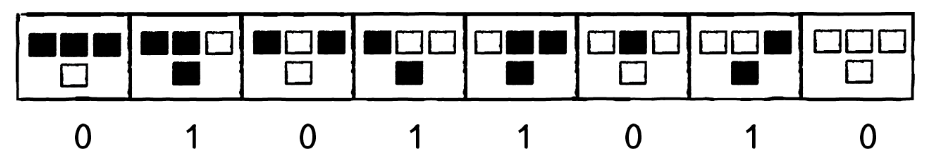

In [8]:
from IPython.display import Image
Image("rule90.png")

This example is illustrated using rule number 90. The binary representation of 90 is:

In [9]:
print( binaryRep(90, 8, numpy_array=True) )

[0 1 0 1 1 0 1 0]


With this rule, the future state of any cell can be determined. To verify that the calculation is correct, a test function is defined. Consider the arbitrary rule number 167.

In [10]:
print( binaryRep(167, 8) )

10100111


If the state of a cell is $1$, the left neighbor has state $1$, and the right neighbor has state $1$, then rule number 167 says that the next generation of the cell will have state $1$. Note that the order of 3-bit numbers corresponds to the above diagram.

In [11]:
rules(1,1,1,222) # Output matches expectation.

'1'

In [12]:
def test_rules(rule_num):
    ''' Test all possibile output for a rule number
    '''
    ruleset = binaryRep(rule_num, 8) # Rule in binary

    assert rules(1,1,1, rule_num) == ruleset[0], 'Unexpected rule output'
    assert rules(1,1,0, rule_num) == ruleset[1], 'Unexpected rule output'
    assert rules(1,0,1, rule_num) == ruleset[2], 'Unexpected rule output'
    assert rules(1,0,0, rule_num) == ruleset[3], 'Unexpected rule output'
    assert rules(0,1,1, rule_num) == ruleset[4], 'Unexpected rule output'
    assert rules(0,1,0, rule_num) == ruleset[5], 'Unexpected rule output'
    assert rules(0,0,1, rule_num) == ruleset[6], 'Unexpected rule output'
    assert rules(0,0,0, rule_num) == ruleset[7], 'Unexpected rule output'
    
test_rules(167)

A more compact version of rules1 can be implemented using a dictionary.

In [13]:
def rules1(a, b, c, rule_number):
    '''
    Determines next generation state for cell b, with neighbors a and c (left and right), based
    on the passed rule_number.
    Returns new state of cell b
    '''
    ruleset = binaryRep(rule_number, 8, numpy_array=True) # Generate 8-bit binary number representing rule number
    
    # Possible states - in same order as 'Nature of Code' document
    truple = [(1,1,1), (1,1,0), (1,0,1), (1,0,0), (0,1,1), (0,1,0), (0,0,1), (0,0,0)]
    
    # Make lookup dict, to associate each state with future state
    lookup_dict = {} # Initialize dictionary
    for indx,lmr in zip(range(8),truple): # Range is used to iterate through elements of ruleset (indices 0-7=range(8))
        lookup_dict[lmr] = ruleset[indx] 
        # Ex: 1st key:(1,1,1), 1st value: ruleset[0]= first digit of binary representation of rule_number
    
    return lookup_dict[a,b,c]

In [14]:
# Quick check to see if rules and rules1 are producing same output:
truple = [(1,1,1), (1,1,0), (1,0,1), (1,0,0), (0,1,1), (0,1,0), (0,0,1), (0,0,0)]

rule_number = num = np.random.choice(np.arange(0,256), size=1 )[0] # Select random rule_number from 0-255

for t in truple:
    print( rules(t[0], t[1], t[2], rule_number), ' ', rules1(t[0], t[1], t[2], rule_number) )
    
# Not the best test. but time constraints limit the amount of "extra" components

0   0
1   1
0   0
0   0
0   0
1   1
1   1
0   0


The two functions, rule and rule1 serve the same purpose, however rule1 contains a ridiculous amount of conditional statements, and is very slow.

We have now determined how to calculate the components of 1-dimensional CA; the grid, the state of a cell in the grid, and the states of the neighboring cells. Next, we classify the CA.

Wolfram, in "A New Kind of Science" defined four classes for cellular automata$^3$:

Class 1: Nearly all initial patterns evolve quickly into a stable, homogeneous state. Any randomness in the initial pattern disappears.
    
Class 2: Nearly all initial patterns evolve quickly into stable or oscillating structures. Some of the randomness in the initial pattern may filter out, but some remains. Local changes to the initial pattern tend to remain local.
    
Class 3: Nearly all initial patterns evolve in a pseudo-random or chaotic manner. Any stable structures that appear are quickly destroyed by the surrounding noise. Local changes to the initial pattern tend to spread indefinitely.
    
Class 4: Nearly all initial patterns evolve into structures that interact in complex and interesting ways, with the formation of local structures that are able to survive for long periods of time.
    
The following four plots are examples of each class. Note that these plots were obtained using the code that follows in question #2.

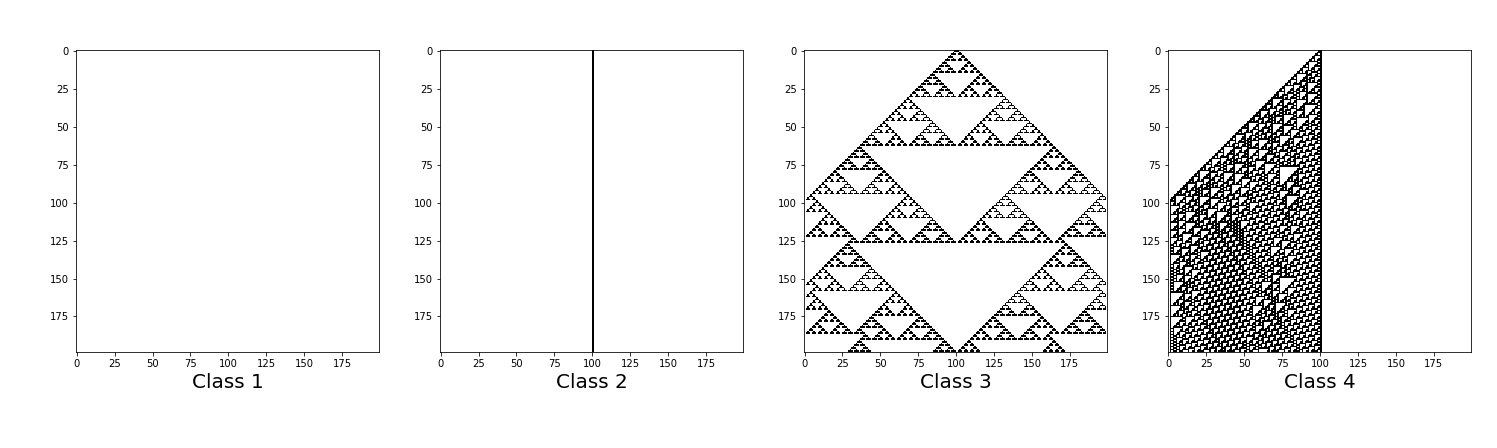

In [15]:
Image("Classes.png")

### #2 Write a program to generate a sequence for $N=64$ grid cells and an arbitrary rule

A starting point is required for the grid. The standard Wolfram model is to start the first generation with all zeros, except for a $1$ in the middle of the grid.

In [16]:
ncells = 64 # N=64 
nsteps = 200 # number of generations

cells = np.zeros(ncells, dtype=np.int8) # Create array of 64 zeros, of type 8-bit unsigned integer
# 8-bit integers are used to be consistent with the output of the rules function 
cells[ncells//2] = 1 # Set middle (or index below median) to 1

A function is needed that will determine the state of each of the 64 cells, in the next generation. There are two subtleties that need to be considered.

So far the next generation of a cell is computed using both its current state and the current states of its neighbors. This algorithm is not well-defined for the edges. The "Nature of Code" document$^2$ presents three possible solutions:

1. Edges remain constant
2. Edges wrap around
3. Edges have different neighborhoods and rules

For simplicity, we will use option 1.

The second point of concern is how to calculate the next generation. Considering we are working with arrays; the most efficient option is to use matrix operations. An alternative is to use an iterative method. Again, for simplicity the latter method will be implemented.

If we iterate through cells, one at a time, then we must be careful not to use "update" (next generation) states when considering the next state of a cell. To avoid this bug, a copied version of the array will be updated using values calculated from the old array. 

In [17]:
def cellular_step(cells, rule_number=90):
    '''
    Calculates the next generation state for 1D grid of cells.
    Parameters:
        cells: 1D Array containing current state of each cell
        rule_number: Integer from 0-255 indicating rule used to update state
    Returns
        New generation of 1D grid of cells
    '''
    newcells = np.zeros(len(cells), dtype=np.int8) # Array to hold new generation of state

    # For each cell in array: obtain state and states of neighbors, calculate new state using rules1 function
    # and update cell state in newcells
    for i in range(1,len(cells)-1):
        left = cells[i-1]
        middle = cells[i]
        right = cells[i+1]
        newstate = rules1(left, middle, right, rule_number)
        newcells[i] = newstate
        
    cells = newcells # Update cells to new generation and return
    return cells

Finally, a main function is defined that puts all this together and returns the sequence.

In [18]:
def sequence_generator(ncells, nsteps, rule_number=90):
    '''
    Determines the sequence of state arrays which represent each generation of a 1D cellular-automaton
    Parameters:
        ncells: Number of cells in the 1D grid
        nsteps: Number of generations
        rule_number: Integer from 0-255 indicating rule used to update state
    Returns
        2D array containing the sequence of a 1D cellular-automaton 
    '''

    cells = np.zeros(ncells, dtype=np.int8) # Create array of 64 zeros, of type 8-bit unsigned integer
    cells[ncells//2] = 1 # Set middle (or index below median) to 1
    
    sequence = np.ndarray( [nsteps, len(cells)], dtype=np.int8 ) # Initialize grid
    

    for n in range(nsteps):
        cells = cellular_step(cells, rule_number)
        sequence[n,:] = cells

    return sequence

The sequence will contain a bunch of rows, filled with zeros and ones. Printing this isn't visually pleasing, so we will use imshow from matplotlib (just as we did when we studied The Mandelbrot Set). 

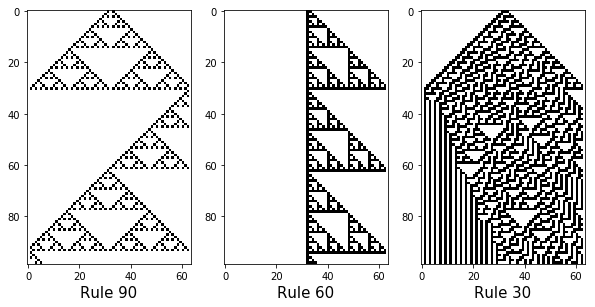

In [19]:
# Determine sequence of 64 cells, over 99 generations for rule 90, rule 60, and rule 30
ca_sequence_90 = sequence_generator(ncells=64, nsteps=99, rule_number=90) 
ca_sequence_60 = sequence_generator(ncells=64, nsteps=99, rule_number=60)
ca_sequence_30 = sequence_generator(ncells=64, nsteps=99, rule_number=30)

fig = plt.figure(figsize=(10,10)) # Set plot size 
ax1 = plt.subplot(1,3,1) # Subplot 1
ax1.set_xlabel('Rule 90', fontsize=15)
plt.imshow(ca_sequence_90, cmap="Greys") # Plot image with a color scheme that won't kill an ink cartridge

ax2 = plt.subplot(1,3,2) # Subplot 2
ax2.set_xlabel('Rule 60', fontsize=15)
plt.imshow(ca_sequence_60, cmap="Greys")

ax3 = plt.subplot(1,3,3) # Subplot 3
ax3.set_xlabel('Rule 30', fontsize=15)
plt.imshow(ca_sequence_30, cmap="Greys")

plt.show()

It is very easy to verify that rule 90 is working correctly, as pretty much any source on cellular automata provide this as an example.

Each plot (and SEVERAL more that I played around with) matched the plots generated by running the code provided in the class notes.

Finally, rules 0, 1, 15, 30, 110, 126, and 150 were found to visually match the plots in this article$^4$: https://pdfs.semanticscholar.org/2c5f/c1de950b1f215916dba1557ee2a9d95295a0.pdf

### #3 Determine which 5 rules appear to be most random by estimating steady-state entropy after many steps.

Recall from our work done in assignment #2:

$^{5}$J. Willard Gibbs derived a formula that computes the entropy of a system, based on the probability distribution of its possible microstates.

$$S=-k_{{\text{B}}}\,\sum _{i}p_{i}\ln \,p_{i}$$

Where $k_{{\text{B}}}$ is Boltzmann's constant. For our analysis it will simply be viewed as a scaling factor, and as such is omitted from calculations.

The logarithm is often taken with base 2 to produce a result in terms of bits per symbol.
$$  H = -\sum_{i=1}^n p_i \; log_2{p_i} = -\frac{1}{\ln 2} \,\sum_{i=1}^n p_i \; \ln{p_i} \qquad [1]$$

Since

$$ log_2(p_i)=\frac{ln(p_i)}{ln(2)} \qquad$$

We will use this formula to compute the entropy of our CA. If we choose an arbitrarily lare number of time-steps, then we expect to see the most random plots of the CA for the largest calculated entropy.

We will reuse the catalogList function from assignment #2, which will create a dictionary of zero and one counts, and define a function that computes the probability of $0$ or $1$ (or both) given a rule number.

NOTE: This method did not procude the intended results, however the following is include for completeness of my analysis.

In [20]:
def catalogList(string):  
    '''
    Counts the number of unique chars in a string and generates a list of the unique chars
    Parameter;
        string: String to be analyzed
    Returns
        dictionary containing unique chars and respective counts
    '''
    char_dict = {} # Dictionary to store unique values and their respective counts
    for symbol in string:
        if symbol in char_dict:
            char_dict[symbol] += 1  # If already in dictionary then increment count
        else:
            char_dict[symbol] = 1  # Else add to dictionary

    return char_dict
  
def rule_prob(rule_number):
    '''
    Calculates and returns the probability of either zero or one, or both, occurring in the binary representation
    of the rule number
    '''
    ruleset = binaryRep(rule_number, 8, numpy_array=True) # Obtain 8-but bin representation of the rule, in an array
    bin_dict = catalogList(ruleset) # Determine counts of zeros and ones
    values = list(bin_dict.values()) # Typecast dict values (counts) to a list for easier access
    probs = values / np.sum( values ) # Calc the probability of number(s) occurring in bin representation of the rule
    
    return probs

To verify this is calculating probabilities as expected, let's compare the output to some expected values.

In [21]:
print( 'Rule 0:', binaryRep(0, 8), '\nRule 1:', binaryRep(1, 8) )
print( 'Probabilities for Rule 0:', rule_prob(0), '\nProbabilities for Rule 1:', rule_prob(1) )

Rule 0: 00000000 
Rule 1: 00000001
Probabilities for Rule 0: [1.] 
Probabilities for Rule 1: [0.875 0.125]


It looks like the function is performing as anticipated.

Now we will use these probabilities, along with late state counts, to determine the entropy. Note that for rule $0$ and rule $255$ there is only one number in the rule number. This means the probability of that number occurring is $1$. Therefore the entropy is zero ($ln(1) = 0$). We will omit these boundary points from consideration, as (1,1,1) and (0,0,0) both result in zeros across the board, which is clearly not very random. Similarly, the sequence may contain all zeros or all ones, so we must be careful when calculating the entropy.

In [22]:
def calc_entropy(sequence, rule_number):
    '''
    Calculates the entropy of a binary state system, described by the sequence parameter.
    Function assumes rule number is not 0 or 255, to avoid extra conditional statements.
    Returns
        The entropy of the sequence based on probability described by rule number
    '''
    probs = rule_prob(rule_number) # Calculate probabilities
    
    bin_dict = catalogList(sequence) # Determine counts of zeros and ones
    values = list(bin_dict.values()) # Typecast dict values (counts) to a list for easier access
    
    if len(values) < 2: # If sequence has only zeros or ones:
        if 0 in bin_dict.keys(): # If sequence is all zeros
            entpy = - ( values[0] * probs[0] * np.log(probs[0]) ) / np.log(2.0)
        else: # Otherwise sequence is all ones
            entpy = - ( values[0] * probs[1] * np.log(probs[1]) ) / np.log(2.0)
    else:
        entpy = - ( (values[0] * probs[0] * np.log(probs[0]) ) + (values[1] * probs[1] * np.log(probs[1]) ) ) / np.log(2.0)
    
    return entpy

We are now ready to test this entropy calculation. A list is compiled for each rule numbers 1-254 at 199 time-steps (remember we are omitting rules 0 and 255). As an approximation; we will use the last ten generations of a late time sequence and take the average.

So we don't keep calculating these late time sequences, create a list that holds them for rules 1-254.

In [23]:
seq_list = [0] # Declare list for late time sequences. Add 0 as first element to match indices with rule numbers
for rule in range(1,255): # For rules 1-254 (omit 0 and 255)
    ca_sequence = sequence_generator(ncells=64, nsteps=199, rule_number=rule) # determine late time sequence
    seq_list.append(ca_sequence)

In [24]:
entropy_list = np.array( [] ) # Initialize list to hold entropy values

for rule in range(1,255): # For rules 1-254 (omit 0 and 255)
    
    ca_sequence = seq_list[rule] # determine late time sequence
    sum_entropies = 0 # Define temp variable
    
    for i in range(1,11): # For the last ten generations in the sequence:
        sum_entropies += calc_entropy(ca_sequence[-i], rule) # Add the entropy to the temp variable
    
    entropy_list = np.append(entropy_list, sum_entropies/10.0) # Divide summed entropy by 10 (average) and add to list

To find the 5 largest entropies, we will use an iterative function:

In [25]:
def max_finder(a_list):
    '''
    Determines the 5 largest values in a list, and returns these values, as well as the indices in array
    where they occur.
    Return variable is a 2-tuple containing a list of the entropies and a list of the indices
    '''
    first, second, third, fourth, fifth = 0, 0, 0, 0, 0
    indx1, indx2, indx3, indx4, indx5 = 0, 0, 0, 0, 0
    
    for i in range(len(a_list)):
        if a_list[i] > first:
            fifth, indx5 = fourth, indx4
            fourth, indx4 = third, indx3
            third, indx3 = second, indx2
            second, indx2 = first, indx1
            first, indx1 = a_list[i], i
        elif a_list[i] > second:
            fifth, indx5 = fourth, indx4
            fourth, indx4 = third, indx3
            third, indx3 = second, indx2
            second, indx2 = a_list[i], i
        elif a_list[i] > third:
            fifth, indx5 = fourth, indx4
            fourth, indx4 = third, indx3
            third, indx3 = a_list[i], i
        elif a_list[i] > fourth:
            fifth, indx5 = fourth, indx4
            fourth, indx4 = a_list[i], i
        elif a_list[i] > fifth:
            fifth, indx5 = a_list[i], i
        
    entropy_list = [first, second, third, fourth, fifth]
    index_list = [indx1, indx2, indx3, indx4, indx5]
        
    return entropy_list, index_list

Recall that rule number 0 and 255 were omitted from out calculations. Therefore, the index for which these maximum values occurred, are actually 1 less than the true rule number. To fix this, we will simply add 1 to each of the indices.

In [26]:
# Find 5 largest entropies and their indices
max_list = max_finder(entropy_list)

for indx in range(len(max_list[1])):
    max_list[1][indx] += 1

print('5 largest entropies:', max_list[0], '\nRule Number:', max_list[1])

5 largest entropies: [33.96089998269225, 33.96089998269225, 33.96089998269225, 33.96089998269225, 33.96089998269225] 
Rule Number: [134, 138, 152, 162, 168]


At this point the only real way we have to check these values is to plot them and see if they coincide with our expectations.

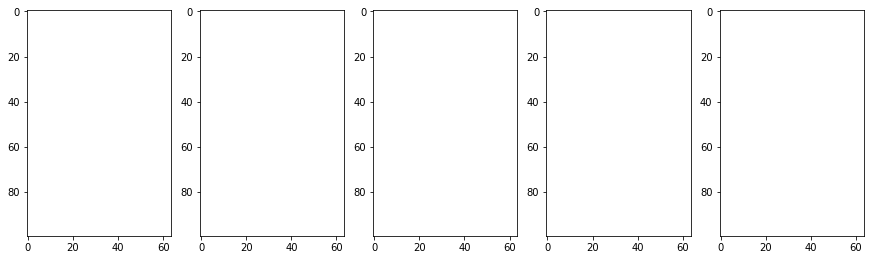

In [27]:
fig = plt.figure(figsize=(15,10)) # Set plot size

for i in range(len(max_list[1])):
    ca_sequence = seq_list[max_list[1][i]]
    plt.subplot(1, 5, i+1)
    plt.imshow(ca_sequence[-100:], cmap='Greys')

plt.show()

Well, these plots are not what I would consider to be random. It looks like each CA has converged to all zeros. After having gone through my code, I do not believe the problem lies there. It seems as though our definition of entropy may not be the best measure of randomness, when it comes to our particular situation. For each rule, the state appears to be constant from generation to generation. This does not coincide with our intuitive dentition of "random".

A change of thinking is in order. For these rules, it is easy to see that calculating the change of entropy from generation to generation would yield a value of zero (or close to it). Perhaps we can determine the most random rules by analyzing the change in entropy between generations. Similar to the previous method, we will find the average change over the last ten generations of a late time sequence. 

NOTE: From trial and error, it was found that certain rules produce late-state generations that go from nearly all zeros to nearly all ones, for successive states. It comes as no surprise that the change in entropy is rather large for these rules, however I wouldn't consider them random. To perform a search where these rules weren't established as the most random it was found that comparing "every-other" generation proved to be effective. Further, taking the average of the entropy differences for indices $[-1, -(2i - 1)]$ over a range of i's resulted in quite random looking plots.

In [28]:
def entropy_diff(entropy_list):
    diff_list = np.array( [] ) # Initialize list to store difference in entropies between 2 generations
    
    for rule in range(1,255): # For rules 1-254 (omit 0 and 255)
    
        ca_sequence = seq_list[rule] # determine late time sequence
        entpy_diff = 0 # Define temp variable
    
        for i in range(10): # For the last ten generations in the sequence:
            e1 = calc_entropy(ca_sequence[-1], rule) # Calculate entropy of last generation
            e2 = calc_entropy(ca_sequence[-(2*i+1)], rule) # Calculate entropy of third-last (fifth-last, etc.) generation
            entpy_diff += np.abs( e1 - e2 ) # Calculate change in entropy between the two generations
            
        diff_list = np.append(diff_list, entpy_diff/10.0) # Append average change in entropy to a list
    
    return diff_list

In [29]:
delta_entropy = entropy_diff(entropy_list) # Compute a list of average late-state entropy differences for rules 1-254

In [30]:
max_list = max_finder(delta_entropy) # Find 5 largest entropy differences and their indices

# Correct index to coincide with rule number
for indx in range(len(max_list[1])):
    max_list[1][indx] += 1

print('5 largest entropies:', max_list[0], '\nRule Number:', max_list[1])

5 largest entropies: [1.5097750043269378, 1.1512034407992893, 0.6517491413584213, 0.4914829590571742, 0.4914829590571692] 
Rule Number: [126, 129, 161, 41, 121]


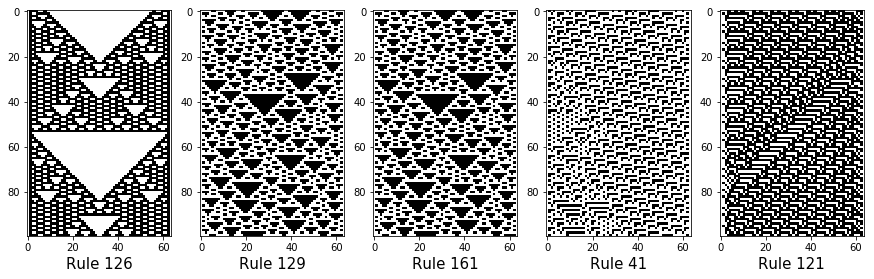

In [31]:
fig = plt.figure(figsize=(15,10)) # Set plot size

for i in range(len(max_list[1])): # For each rule number determined to have largest late-state entropy difference
    ca_sequence = seq_list[max_list[1][i]] # Pull the sequence
    ax = plt.subplot(1, 5, i+1) # Set subplot
    ax.set_xlabel('Rule '+str(max_list[1][i]), fontsize=15) # Add rule number as title
    plt.imshow(ca_sequence[-100:], cmap='Greys') # Plot late-time behavior of CA

plt.show()

Alright, this is looking a little better than the first attempt. These plots definitely appear to have a lot going on. It is interesting to note that rules 129 and 161 appeared to be equivalent. According to Wolfram there are 88 fundamentally inequivalent rules; 129 and 161 being two of them$^6$. Clearly the small snapshot we have here isn't enough to full appreciate how each CA evolves- it's just a fraction of what can occur.

It is important to note that while the general definition of entropy seems to be 'a measure of disorder/ randomness', clearly attention is required such that simply plugging numbers into a formula can lead to misleading results.

### #4 Write a function to generate a pseudorandom sequence 64-bit integer based on a cellular automaton using the highest entropy rule.

I decided this was as good a time as any to experiment with writing code in an external text editor and importing the resulting .py file.

random_ca.py implements a program that initializes a sequence "matrix" containing multiple generations of the CA's state. When first instantiated; the sequence is initialized to all zeros and a randomly generated 64-bit initial state grid is assigned. The steps() function advances the current state by the specified number. The plot() function will display the last 'nsteps' generations. To get a square plot, the number of steps used was 64.

In [32]:
import random_ca as my_prog # import random.py

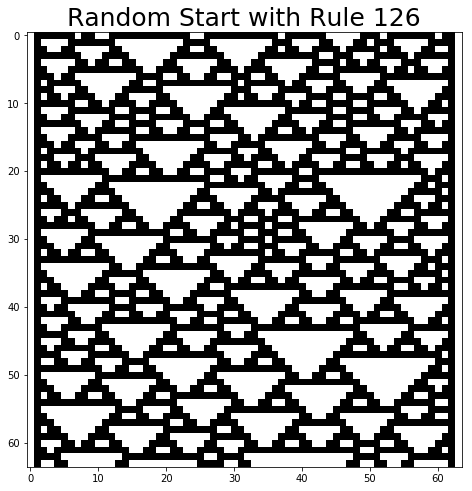

In [33]:
random_126 = my_prog.cellularAutomaton(64,64,126) # Instantiate CA with ncells=nsteps=64 using rule 126 
random_126.steps(64) # Advance the current state by 64 (=nsteps) steps to fill sequence matrix
random_126.plot() # Plot the history of the CA

To get a little more validation for the steps taken, when deciding on a method for estimating the most random rule, let's extend the grid to 200 cells- it "shows-off" how random the CA is behaving.

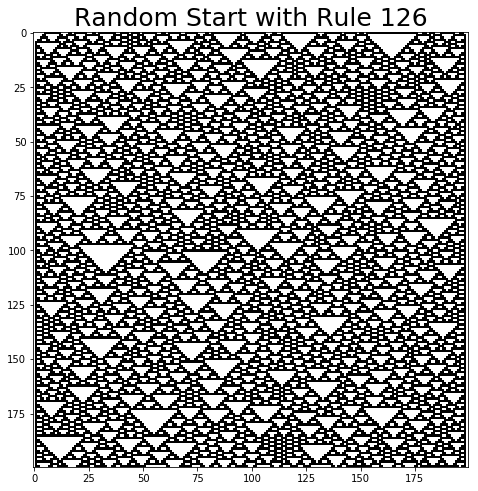

In [34]:
random_126 = my_prog.cellularAutomaton(200,200,126) # ncells=200, nsteps=200
random_126.steps(200)
random_126.plot()

### #5  The game of life

Read this Wikipedia page: https://en.wikipedia.org/wiki/Conway%27s_Game_of_Life

Read the python file in D2L: phys481_game-of-life.py
and work your way through different implementations of the algorithm in stepper0, stepper1...
and play around with the results.

Each of the 5 stepper functions were placed in a python file, steppers.py, to reduce the amount of code in this report.

In [35]:
import steppers as stp # Import steppers.py

We need a grid to pass to the step functions. Anticipating the next 2 questions; we define a function that randomly generates a grid of Booleans, determined by a random process (see doc string below).

In [36]:
def random_grid(nx, ny, p):
    '''
    rand function creates ndarray of shape nx x ny and randomly assigns each 
    element with a number in uniform distribution [0,1). Comparing if greater 
    than probability will generate ndarray of Booleans, where True means the 
    random number was greater than p
    Parameters:
        nx. ny: Number of rows and columns
        p: probability between 0 and 1
    Returns
        nx x ny matrix will boolean elements
    '''
    return np.random.rand(nx, ny) > p

In [37]:
# Create a grids for testing purposes
grid_small = random_grid(4, 4, 0.5)
grid_large = random_grid(100, 100, 0.5)

2 tests will be performed for each stepper function. Test1 will use the smaller grid and Test2 will use the larger. Varying the amount of data that each function has to deal with, will give us an idea of where/ when each function is best suited for the task at hand.

In [38]:
def stepper_test(grid, label):
    '''
    Test displays runtimes for 5 step functions, defined in steppers.py
    for specified grid
    '''
    print('\tStepper0 - ' + label)
    %timeit stp.stepper0(grid)

    print('\n\tStepper1 - ' + label)
    %timeit stp.stepper1(grid)

    print('\n\tStepper2 - ' + label)
    %timeit stp.stepper2(grid)

    print('\n\tStepper3 - ' + label)
    %timeit stp.stepper3(grid)

    print('\n\tStepper4 - ' + label)
    %timeit stp.stepper4(grid)

In [39]:
# Test 1 - 4x4 Grid
#stepper_test(grid_small, 'Small Grid')
# Not run to speed up compilation process. Output is provided below

<pre>
Stepper0 - Small Grid
358 µs ± 5.25 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

	Stepper1 - Small Grid
187 µs ± 845 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)

	Stepper2 - Small Grid
99.4 µs ± 859 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)

	Stepper3 - Small Grid
91.5 µs ± 934 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)

	Stepper4 - Small Grid
69.6 µs ± 1.57 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
</pre>

In [40]:
# Test 2 - 100x100 Grid
#stepper_test(grid_large, 'Large Grid')
# Not run to speed up compilation process. Output is provided below

<pre>
Stepper0 - Large Grid
223 ms ± 10 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

	Stepper1 - Large Grid
108 ms ± 2.98 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

	Stepper2 - Large Grid
1.53 ms ± 7.82 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

	Stepper3 - Large Grid
1.54 ms ± 42.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

	Stepper4 - Large Grid
1.51 ms ± 28.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
</pre>

As expected the large grid significantly lengthened the runtime. To get a better idea of what is going on with these functions I went through steppers.py and figured out what each line of code is doing and added comments to reflect my understanding. See steppers.py for comments.

### #6 Examine the steady-state (long time) behaviour for an initial configuration with 1/2 the cells randomly turned on ($p=0.5$). Calculate mean & standard deviation for at least 3 runs to estimate uncertainty.

In order to get a better understanding of both the Game of Life in general, and OOP in Python, I created a file called game_of_life.py. Please see attached file for my work.

To answers this question I will instantiate a GameOfLife object, step forward by a large amount, and use a getter to pull the state of the grid.

In [41]:
import game_of_life as gol # Import game_of_life.py

The file includes the random_grid function in the same form that we defined in the previous question. We will instantiate a GameOfLife object using a randomly generated grid. To get an idea of what we are dealing with, the plot() function is called.

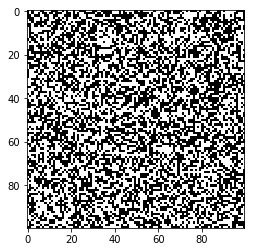

In [42]:
rand_grid = gol.random_grid(100, 100, 0.5) # Generate random 100x100 grid
game1 = gol.GameOfLife(grid=rand_grid) # Instantiate GameOfLife using the grid
game1.plot()

Recall that the grid is actually a matrix with Boolean valued elements. We can print this by calling the appropriate getter.

In [43]:
print( game1.get_grid() )

[[ True False  True ...  True  True  True]
 [ True False  True ... False False  True]
 [ True  True False ... False False  True]
 ...
 [False  True False ...  True  True  True]
 [False  True  True ...  True  True  True]
 [ True  True False ... False False  True]]


The late time behavior can be classified by the number of living cells that remain after a certain amount of time. This can be represented as a fraction of the total number of cells. A dictionary can be created in a similar manner as we used when calculating the entropy. We will define a custom function that returns the fraction.

In [44]:
def fraction_living_cells(gol_obj):
    '''
    '''
    unique, counts = np.unique(game1.get_grid(), return_counts=True)
    game_dict = dict(zip(unique, counts))
    
    if True in game_dict:
        frac = game_dict[True] / ( game1.nx * game1.ny )
    else:
        frac = 0.0
    return frac

In [45]:
fraction_living_cells(game1)

0.4999

This fraction is very close to the 0.5 expected by initializing the grid with probability, p=0.5.

We will now step forward by an arbitrarily large amount, say 100 steps, and calculate the fraction living.

Fraction of living cells after 100 steps: 0.0829


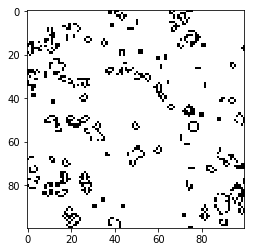

In [46]:
for i in range(100):
    game1.step()

game1.plot()
print('Fraction of living cells after 100 steps:', fraction_living_cells(game1))

The percent of living cells dropped from ~50% to ~10%. To get a bit more of a concrete number, we will take a sample size of 10 and compute the mean and standard deviation.

In [47]:
def get_sample(gol_obj, nsteps, sample_size, p):
    frac_list = np.array([])
    
    for sample in range(sample_size):
        gol_obj.randomize(p)
        for i in range(nsteps): 
            gol_obj.step()
        frac_list = np.append( frac_list, fraction_living_cells(game1) )

    return frac_list

def living_stats(a_list):
    mean = np.round( np.mean(a_list), 5 )
    std = np.round( np.std(a_list), 5 )
    
    return mean, std

In [48]:
sample = get_sample(game1, 100, 10, 0.5)
mean, std = living_stats(sample)

print('Stats for living number of cells, sample size of 10, after 100 steps:')
print('\tMEAN:', mean, '\n\t STD:', std)

Stats for living number of cells, sample size of 10, after 100 steps:
	MEAN: 0.0935 
	 STD: 0.01503


To put these numbers into a little more context it would be helpful to do the same calculations for a range of probabilities, which is covered in the next question. What we can do here is compare the standard deviation to that of the initial (randomly generated) starting counts.

In [49]:
starting_frac = [] # List to hold fraction of initial # cells that are alive

for i in range(10): # For 10 sample points
    game1.randomize(0.5) # "Initialize" the grid
    starting_frac.append( fraction_living_cells(game1) ) # Calculate fraction of living and add to list

mean_i, std_i = living_stats( starting_frac ) # Calculate mean and std of initial living fraction

print('Average Fraction of Living Cells (p=0.5):  ', mean_i)
print('Standard Deviation of Living Cell Fraction:', std_i)

Average Fraction of Living Cells (p=0.5):   0.5
Standard Deviation of Living Cell Fraction: 0.00548


The standard deviation in the fraction of living cells drops from roughly 1% to 0.5% after 100 steps (based on the sample size of 10). This suggests that while the random component of the initial grid configuration, in terms of living cell numbers, is a factor, there is definitely a dependency on "the layout of the initial grid- which of course we expected.

### #7 Examine the steady-state behaviour for a range of initial random densities ranging from $p=0$ to $p=1$.

The same calculation used in #6 can be applied to a range of initial densities.

First, randomly select 25 densities (I played around with the number/ number of steps/ sample size and thought this combination showed decent results with a reasonable runtime).

In [50]:
pvals = np.random.rand(1, 25) # Randomly select 25 numbers from Unif(0,1). 
# Function generations an array, with 1 element which is also an array  
pvals = np.sort( pvals ) # sort the elements, by default- in ascending order

Next, determine the mean and standard deviation for the number of living cells after 100 steps, for a sample size of 25.

In [51]:
mean_vals, std_vals = np.array([]), np.array([]) # Initialize arrays to hold mean and std values for each sample

for pval in pvals[0]: # For every p
    sample = get_sample(game1, nsteps=100, sample_size=25, p=pval) # Generate sample
    mean, std = living_stats(sample) # Calculate sample mean and sample std
    mean_vals = np.append(mean_vals, mean) # Add mean and std to respective list 
    std_vals = np.append(std_vals, std)

In [52]:
import pandas as pd # use pandas to tabulate results

print('TITLE')

df1 = pd.DataFrame({
  'p': pvals[0], # Column 1 - p
  'Mean': mean_vals, # Column 2 - mean
  'Std': std_vals # Column 3 - std
})

print(df1) # Display dataframe

TITLE
       Mean      Std         p
0   0.00000  0.00000  0.039680
1   0.00000  0.00000  0.089365
2   0.00006  0.00024  0.108627
3   0.00006  0.00018  0.111477
4   0.00275  0.00355  0.198609
5   0.01321  0.00688  0.237059
6   0.01505  0.00909  0.239379
7   0.02229  0.00709  0.260748
8   0.03236  0.01027  0.276542
9   0.07772  0.01343  0.367096
10  0.08390  0.01091  0.372301
11  0.08434  0.01193  0.403997
12  0.08928  0.01146  0.411960
13  0.08930  0.01327  0.432010
14  0.09292  0.01106  0.466189
15  0.09124  0.00988  0.474815
16  0.09463  0.01233  0.510676
17  0.09766  0.00706  0.608406
18  0.09808  0.00777  0.614604
19  0.09621  0.00981  0.682731
20  0.09660  0.01001  0.696823
21  0.09654  0.01147  0.772405
22  0.09339  0.01064  0.774651
23  0.00024  0.00035  0.980841
24  0.00000  0.00000  0.999503


It appears that for p < ~0.1 both the mean and standard deviation is quite close to zero. To better visualize this data, we will plot it.

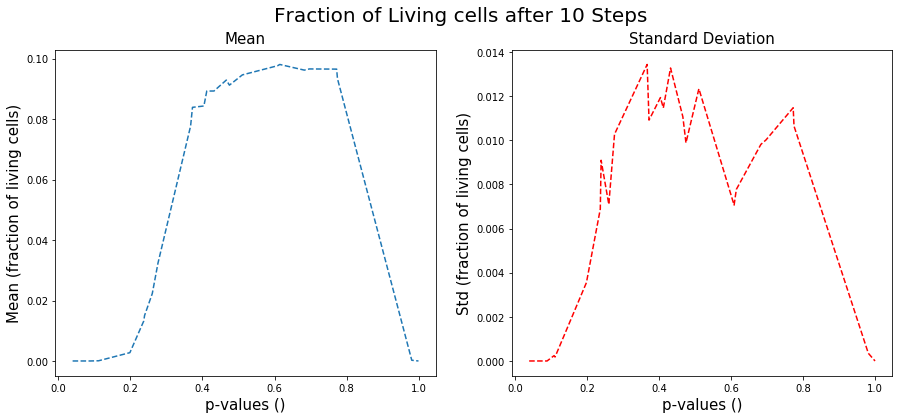

In [53]:
fig = plt.figure(figsize=(15,6)) # Customize plot size
plt.suptitle('Fraction of Living cells after 10 Steps', fontsize=20) # Add super-title to both subplots

ax1 = plt.subplot(1,2,1) # Subplot 1 is mean vs p
plt.xlabel('p-values ()', fontsize=15) # Label axes
plt.ylabel('Mean (fraction of living cells)', fontsize=15)
plt.title('Mean', fontsize=15) # Individual plot title
plt.plot(pvals[0], mean_vals, linestyle='--') # Plot mean

ax2 = plt.subplot(1,2,2) # Subplot 2 is std vs p
plt.xlabel('p-values ()', fontsize=15) # Label axes
plt.ylabel('Std (fraction of living cells)', fontsize=15)
plt.title('Standard Deviation', fontsize=15) # Individual plot title
plt.plot(pvals[0], std_vals, linestyle='--', c='r') # Plot std

plt.show()

The plots would definitely have come out a little better if we had increased the number of sample points, however the number was chosen with compilation time in mind. Either way, you get the same take-away; There seems to be a sort of "sweet-spot" at roughly $p=0.6$ for which the fraction of living cells remaining after 100 steps is at a maximum. The standard deviation appears proportional to the mean- nothing unusual about that. 

So far, we have estimated the steady-state behavior in terms of remaining living cells. There are others way to classify the grid. There are many different types of patterns which are classified by their behavior. The common behavior types include 'Still Lifes', 'Oscillators', and 'Spaceships'.  Perhaps plotting a sequence of steady-state generations will reveal some of those behaviors.

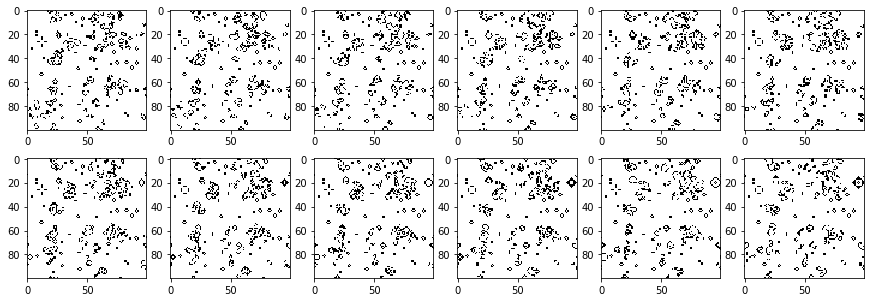

In [58]:
game1.randomize(p=0.5) # Initialize Grid to starting generation

for i in range(100): # Advance by 100 steps
    game1.step()

fig, axes = plt.subplots(2, 6, figsize=(15,5))
# plts.subplots return figure and axes object
# fig can be used to change figure attributes and/ or save
# axes allows for plot customization and/ or subplot features

for ax in axes.flatten(): 
    # plt.subplots return ndarray. Flatten method copies ndarray into a single array
    # which simplifies iteration through subplots
    game1.step() # Separate each plot by a step
    game1.plot(ax)

The above plots are different each time the cell is run however it is usually pretty easy to spot various tetromino patterns$^7$ similar to:

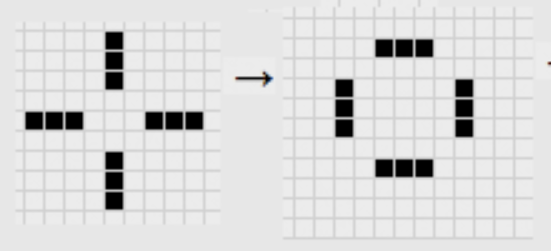

In [55]:
Image("tetromino.png")

Simply looking at a few snapshots is not a very effective method to find and classify these common patterns, however it is interesting to know it can be done (and is relatively easy) for some patterns. A more advanced analysis would include animating the game, and then developing algorithms that could detect various patterns over the life cycle of a game.

## Conclusion

This report started with the analysis of a 1-dimensional CA model. The basics were covered in great detail, with hope that a good understanding would lead to a well-thought-out analysis of the questions posed. There were no issues with implementing the code required to match plots mentioned in the various references. 

Using entropy to determine the most random rules proved to be more difficult. We saw that simply plugging in numbers to the formula did not lead to the results that we expected. In fact, the initial method determined that the most random rules were CA's of Class 1 (patterns evolve quickly into a stable, homogeneous state). After some reconsideration and experimentation, it was found that analyzing the change in entropy proved to be a more efficient method. This was a good example of adapting the analysis, rather than simply bailing on it.

There is no doubt that without a very good understanding of the basic 1D model, the Game of Life would have been extremely difficult to implement and play around with. Thankfully the class notes gave us a head start on the analysis, and there is no shortage of online references.

My first programming language was Java, and I feel like I have been putting off learning OOP in Python for far too long. This was definitely a good introduction to objects in Python. Having done PHYS 381 and a few assignments here in 481, I wasn't so sure that implementing objects would be helpful in the sort of analysis we have been exposed to. It didn't take long for me to change my mind. I found it to be a very natural transition to that way of thinking, so I think that choosing this topic was the right timing to introduce OOP.

I have rough code for animating the Game of Life, however it would still require a few hours of work for it to be "presentable". That being said; I know we will be using a variation of this model for the next assignment, so I will continue to work on that code throughout the week.

Very cool stuff!

### References
[1] Susanna S. Epp, Discrete Mathematics with Applications, Custom Edition for MATH 309

[2] https://natureofcode.com/book/chapter-7-cellular-automata/

[3] https://en.wikipedia.org/wiki/Elementary_cellular_automaton 

[4] https://pdfs.semanticscholar.org/2c5f/c1de950b1f215916dba1557ee2a9d95295a0.pdf

[5] https://en.wikipedia.org/wiki/Entropy_(statistical_thermodynamics)

[6] http://mathworld.wolfram.com/ElementaryCellularAutomaton.html

[7] - http://pi.math.cornell.edu/~lipa/mec/lesson6.html